In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/ssne/trafic_32.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
   creating: trafic_32/00014/00000_00009/
  inflating: trafic_32/00014/00000_00009/00000_00009.jpg  
   creating: trafic_32/00014/00010_00017/
  inflating: trafic_32/00014/00010_00017/00010_00017.jpg  
   creating: trafic_32/00014/00012_00001/
  inflating: trafic_32/00014/00012_00001/00012_00001.jpg  
   creating: trafic_32/00014/00021_00028/
  inflating: trafic_32/00014/00021_00028/00021_00028.jpg  
   creating: trafic_32/00014/00001_00004/
  inflating: trafic_32/00014/00001_00004/00001_00004.jpg  
   creating: trafic_32/00014/00018_00022/
  inflating: trafic_32/00014/00018_00022/00018_00022.jpg  
   creating: trafic_32/00014/00002_00001/
  inflating: trafic_32/00014/00002_00001/00002_00001.jpg  
   creating: trafic_32/00014/00020_00016/
  inflating: trafic_32/00014/00020_00016/00020_00016.jpg  
   creating: trafic_32/00014/00002_00012/
  inflating: trafic_32/00014/00002_00012/00002_00012.jpg  
   creating: trafic_32/000

In [3]:
!cp drive/MyDrive/ssne/inception.py inception.py

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
import random
from scipy import linalg
from inception import InceptionV3

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [6]:
seed = 21
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64
train_val_ratio = 0.8

dataset = datasets.ImageFolder("trafic_32", transform=transform)

classes = dataset.classes

train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=val_size, shuffle=False)

In [8]:
def get_train_images(num):
    return torch.stack([val_set[i][0] for i in range(0,num)], dim=0)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(Encoder, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.seq = nn.Sequential(nn.Linear(input_dim + num_classes, hidden_dim),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(hidden_dim, hidden_dim//2),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(hidden_dim//2, hidden_dim//4),
                                 nn.LeakyReLU(0.2))
        self.fc_mean  = nn.Linear(hidden_dim//4, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim//4, latent_dim)        
        self.training = True
        
    def forward(self, x, c):
        x = torch.flatten(x, 1)
        x = torch.cat((x, self.label_emb(c)), -1)
        x = self.seq(x)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)        
        return mean, log_var

In [33]:
img_shape = (3, 32, 32)
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_classes):
        super(Decoder, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.seq = nn.Sequential(nn.Linear(latent_dim + num_classes, hidden_dim//4),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(hidden_dim//4, hidden_dim//2),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(hidden_dim//2, output_dim))
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x, c):
        x = torch.cat((x, self.label_emb(c)), -1)
        h = self.seq(x)
        x_hat = torch.sigmoid(h)
        x_hat = x_hat.view(x_hat.size(0), *img_shape)
        return x_hat

In [34]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim, num_classes):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=num_classes)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim, num_classes=num_classes)

    def reparameterization(self, mean, var):
        z = torch.randn_like(mean) * var + mean
        return z
                 
    def forward(self, x, c):
        mean, log_var = self.encoder(x, c)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z, c)
        return x_hat, mean, log_var

In [35]:
def generate_images(model, n_imgs, device, show=False):
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device), torch.randint(model.num_classes, (n_imgs,)).to(device))
    generated_imgs = generated_imgs.cpu()
    if n_imgs <= 16 and show:
        grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(15,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()
    return generated_imgs

In [36]:
def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [37]:
def count_fid(generated_imgs, input_imgs):
    model = InceptionV3([InceptionV3.BLOCK_INDEX_BY_DIM[2048]])
    generated_dist = model(generated_imgs)[0] #Zakładam że wygenerowane obrazki są już zdenormalizowane
    orig_dist = model(input_imgs/ 2 + 0.5)[0] #Proszę pamiętać o denormalizacji obrazków treningowych
    fid = calculate_frechet_distance(orig_dist.squeeze().numpy(), generated_dist.squeeze().numpy()) #Funkcja calculate_frechet_distance jest w notebooku z poprzednich zajęć
    return fid

In [44]:
vae = VAE(latent_dim=128, hidden_dim=512, x_dim=3072, num_classes=len(classes)).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


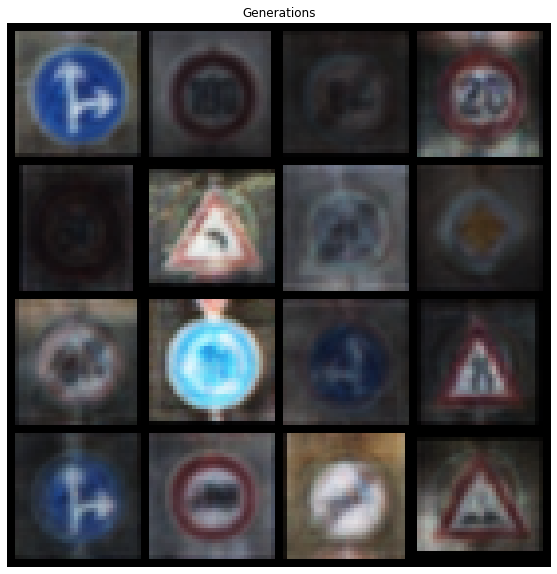

Loading cached inception model for validation
Epoch 0 loss 2795.1007583524934, test L1 = 0.07013479620218277, fid = 129.29828068234696
Epoch 1 loss 2793.632587844631, test L1 = 0.06988225132226944
Epoch 2 loss 2795.0995960119058, test L1 = 0.0702095776796341
Epoch 3 loss 2789.385225128982, test L1 = 0.07030223309993744
Epoch 4 loss 2787.2949462393394, test L1 = 0.06995655596256256
Epoch 5 loss 2787.628888380746, test L1 = 0.07016375660896301
Epoch 6 loss 2782.871284282863, test L1 = 0.07023236900568008
Epoch 7 loss 2782.7618552400236, test L1 = 0.06988587230443954
Epoch 8 loss 2780.9726609736986, test L1 = 0.07041286677122116
Epoch 9 loss 2780.3238660264647, test L1 = 0.07051192969083786


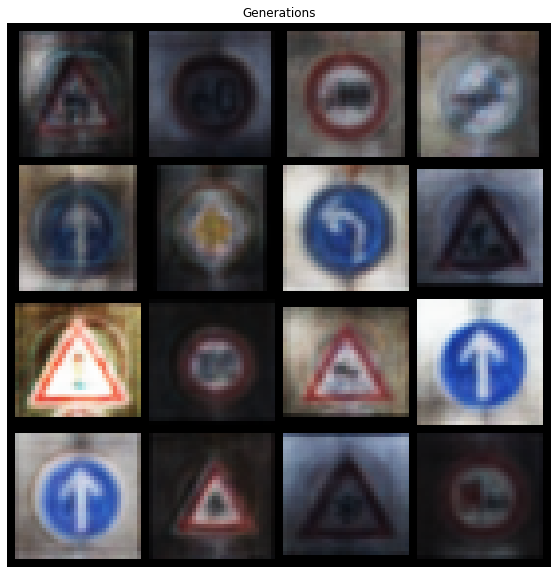

Loading cached inception model for validation
Epoch 10 loss 2777.5693882089527, test L1 = 0.07009528577327728, fid = 132.04877405821054
Epoch 11 loss 2777.1658603023366, test L1 = 0.06995537877082825
Epoch 12 loss 2774.904183630545, test L1 = 0.06987983733415604
Epoch 13 loss 2772.4853245876957, test L1 = 0.07000501453876495
Epoch 14 loss 2772.031152853412, test L1 = 0.0698285698890686
Epoch 15 loss 2770.145420144386, test L1 = 0.0698600709438324
Epoch 16 loss 2766.905762340289, test L1 = 0.06996456533670425
Epoch 17 loss 2763.5599878625812, test L1 = 0.0705149918794632
Epoch 18 loss 2765.5922711716166, test L1 = 0.07021806389093399
Epoch 19 loss 2762.5618544693148, test L1 = 0.0696491077542305


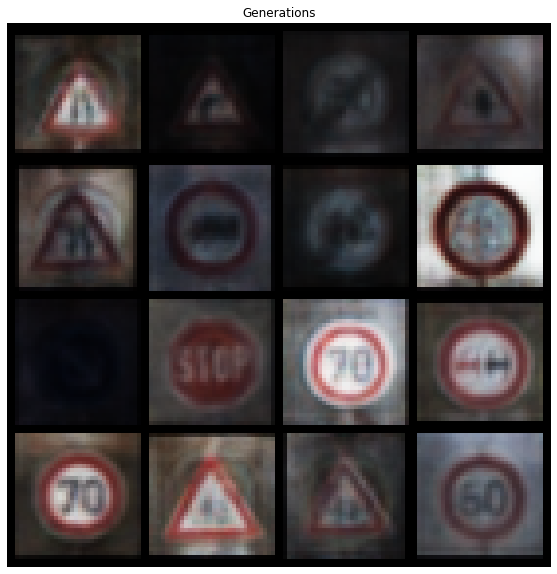

Loading cached inception model for validation
Epoch 20 loss 2759.267395205993, test L1 = 0.07003681361675262, fid = 129.76488987200327
Epoch 21 loss 2760.6852106844094, test L1 = 0.07001788169145584
Epoch 22 loss 2757.932089749276, test L1 = 0.07010756433010101
Epoch 23 loss 2757.4279029364498, test L1 = 0.06958435475826263
Epoch 24 loss 2755.941342293609, test L1 = 0.06964489817619324
Epoch 25 loss 2754.2694467206593, test L1 = 0.06977609544992447
Epoch 26 loss 2751.6644600365166, test L1 = 0.07027004659175873
Epoch 27 loss 2750.797543372253, test L1 = 0.06942062824964523
Epoch 28 loss 2749.1013002104282, test L1 = 0.06956726312637329
Epoch 29 loss 2748.5928664197745, test L1 = 0.06964077055454254


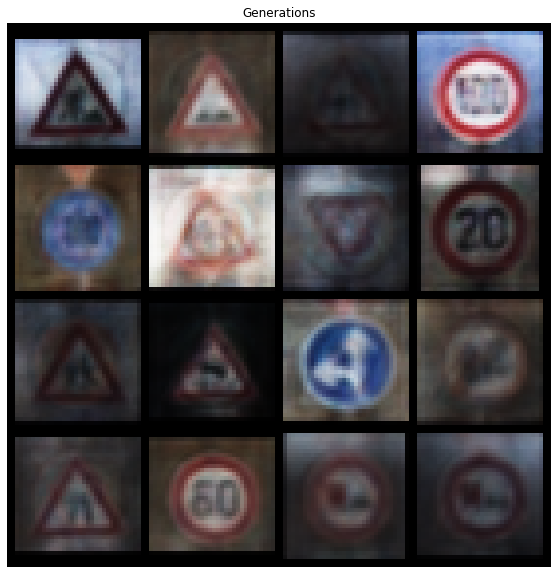

Loading cached inception model for validation
Epoch 30 loss 2748.4177970497767, test L1 = 0.06983606517314911, fid = 130.65167987783428
Epoch 31 loss 2744.6635440119417, test L1 = 0.070003941655159
Epoch 32 loss 2744.1171479079485, test L1 = 0.06940308213233948
Epoch 33 loss 2740.925325164484, test L1 = 0.06971864402294159
Epoch 34 loss 2740.970728670264, test L1 = 0.06943314522504807
Epoch 35 loss 2739.7991585352756, test L1 = 0.06951046735048294
Epoch 36 loss 2738.4275626436997, test L1 = 0.06938755512237549
Epoch 37 loss 2737.376378822715, test L1 = 0.06972070038318634
Epoch 38 loss 2736.080873570957, test L1 = 0.0698234885931015
Epoch 39 loss 2733.855678333042, test L1 = 0.06930121034383774


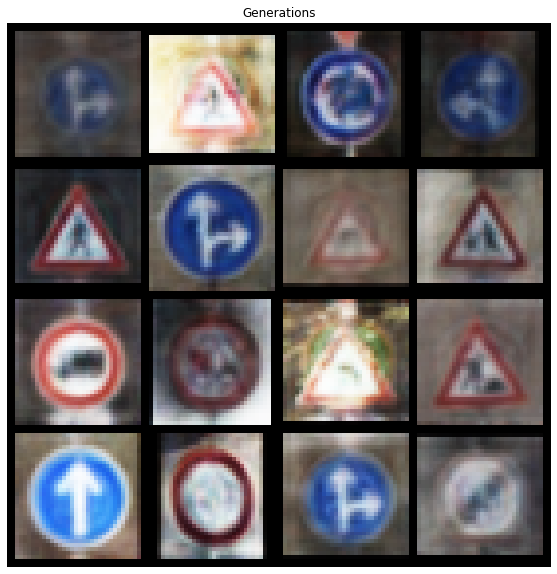

Loading cached inception model for validation
Epoch 40 loss 2731.9362260931134, test L1 = 0.06974492222070694, fid = 131.05635649112983
Epoch 41 loss 2730.805059304791, test L1 = 0.06952227652072906
Epoch 42 loss 2731.1284894923815, test L1 = 0.06918912380933762
Epoch 43 loss 2728.6923790832643, test L1 = 0.06922437995672226
Epoch 44 loss 2728.441585874849, test L1 = 0.06953215599060059
Epoch 45 loss 2726.7815161120384, test L1 = 0.06942179799079895
Epoch 46 loss 2727.9684110746366, test L1 = 0.06927642971277237
Epoch 47 loss 2723.9615426306327, test L1 = 0.06937678158283234
Epoch 48 loss 2722.0149602015977, test L1 = 0.06929879635572433
Epoch 49 loss 2721.2609167778805, test L1 = 0.06935469806194305


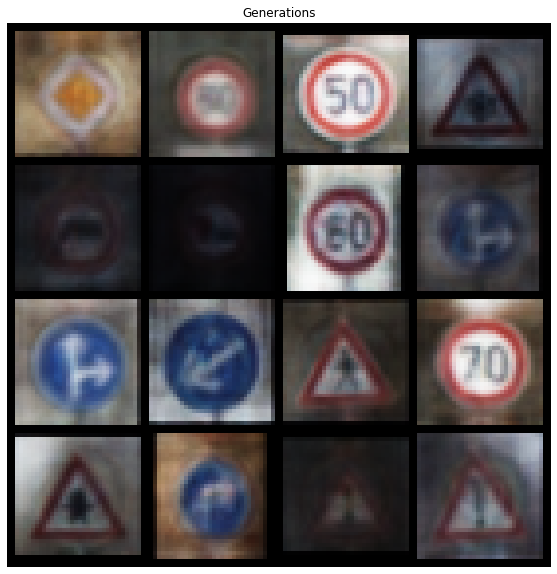

Loading cached inception model for validation
Epoch 50 loss 2721.458987109773, test L1 = 0.06949227303266525, fid = 131.27633560723928


In [49]:
num_epochs = 150
for n in range(num_epochs+1):
    losses_epoch = []
    for x, labels in iter(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        out, means, log_var = vae(x, labels)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    L1_list = []
    for x, labels in iter(val_loader):
        x  = x.to(device)
        labels = labels.to(device)
        out, _, _ = vae(x, labels)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    if n % 10 == 0:
        generate_images(vae, 16, device, show=True)
        generated_imgs = generate_images(vae, 50, device)
        input_imgs = get_train_images(50)
        fid = count_fid(generated_imgs, input_imgs)
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}, fid = {fid}")
    else:
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


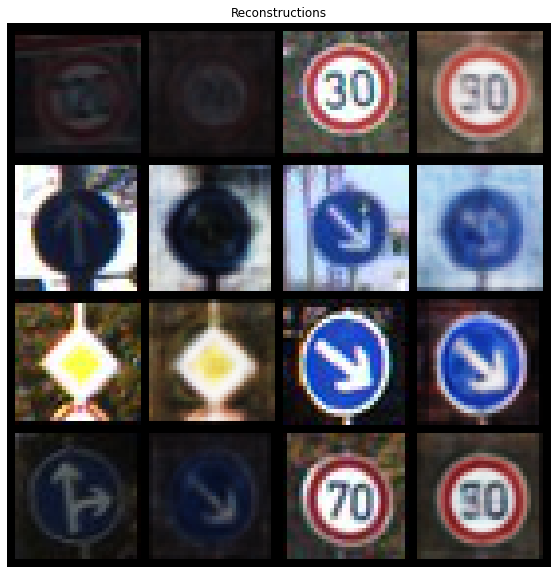

In [ ]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


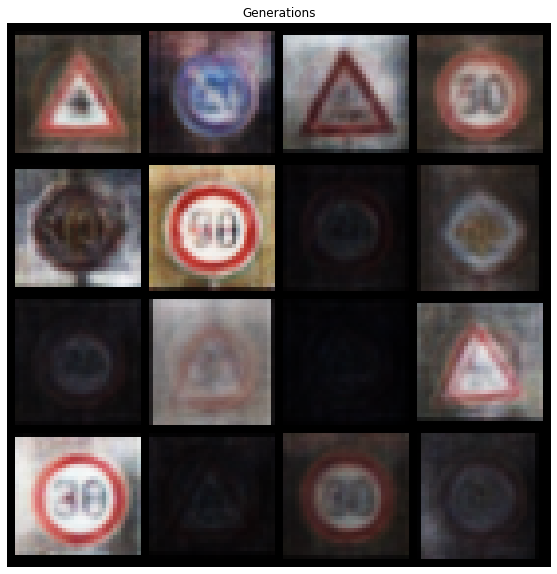

tensor([[[[2.6283e-02, 2.6655e-02, 2.9923e-02,  ..., 3.7059e-02,
           3.9536e-02, 4.0659e-02],
          [3.2001e-01, 2.8643e-01, 3.0139e-01,  ..., 3.6947e-01,
           3.7092e-01, 4.1193e-01],
          [3.1350e-01, 2.7744e-01, 2.9296e-01,  ..., 3.8923e-01,
           4.0126e-01, 4.1990e-01],
          ...,
          [2.2018e-01, 2.1034e-01, 2.1446e-01,  ..., 3.4471e-01,
           3.4753e-01, 3.9566e-01],
          [2.2978e-01, 2.4180e-01, 2.4720e-01,  ..., 3.4344e-01,
           3.5610e-01, 4.1894e-01],
          [2.3504e-03, 3.4527e-03, 3.4157e-03,  ..., 3.8874e-03,
           3.5587e-03, 2.9847e-03]],

         [[2.2094e-02, 2.1719e-02, 2.3342e-02,  ..., 3.1700e-02,
           3.3209e-02, 3.3472e-02],
          [3.0348e-01, 2.6111e-01, 2.6269e-01,  ..., 3.3732e-01,
           3.4775e-01, 3.8893e-01],
          [2.7126e-01, 2.3997e-01, 2.4727e-01,  ..., 3.4926e-01,
           3.6793e-01, 3.8778e-01],
          ...,
          [1.9163e-01, 1.8531e-01, 1.8723e-01,  ..., 2.8537

In [ ]:
generate_images(vae, 16 , device, show=True)

In [ ]:
generated_imgs = generate_images(vae, 1000, device)
torch.save(generated_imgs.detach(),"piatek_Pak_Robaczewski.pt")

In [46]:
def generate_class_images(model, n_imgs, label, device):
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device), torch.LongTensor(np.ones(n_imgs) * label).to(device))
    generated_imgs = generated_imgs.cpu()
    return generated_imgs

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


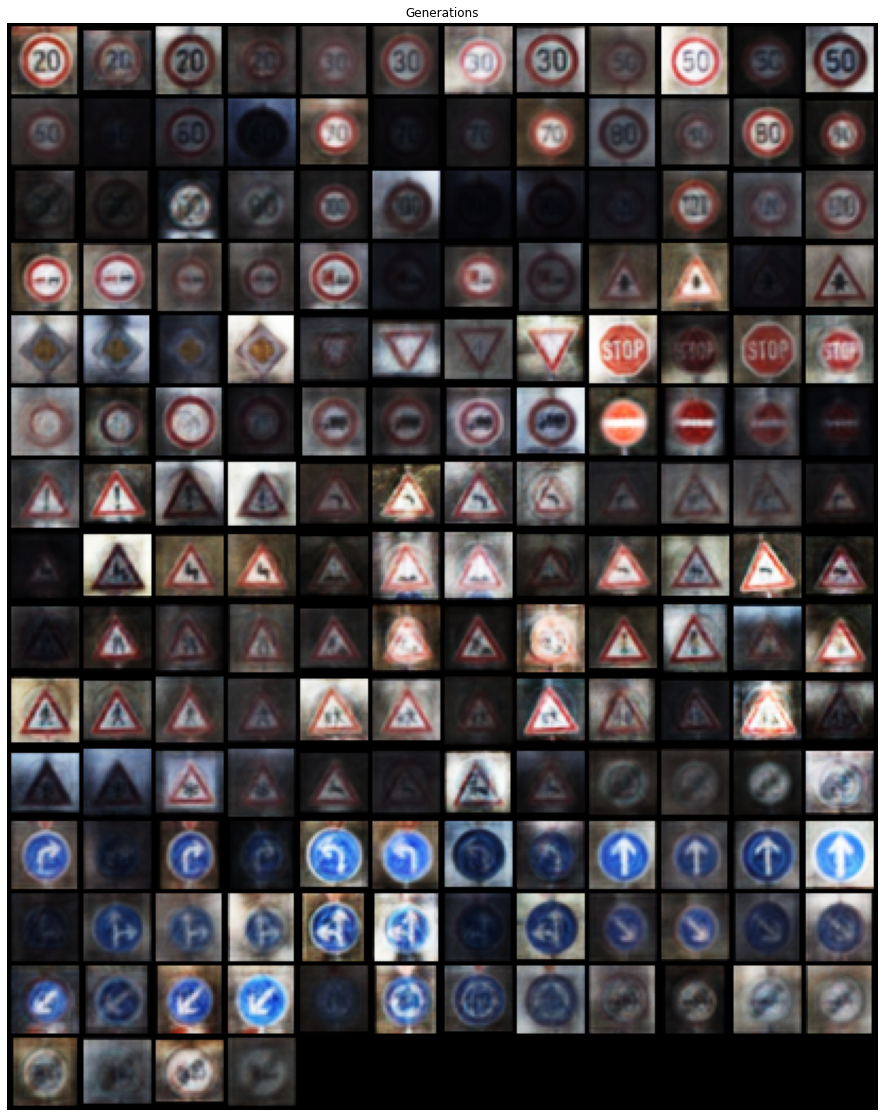

In [50]:
all_imgs = generate_class_images(vae, 4, 0, device)
for i in range(1,len(classes)):
    imgs = generate_class_images(vae, 4, i, device)
    all_imgs = torch.concat((all_imgs, imgs))

grid = torchvision.utils.make_grid(all_imgs, nrow=12, normalize=False, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(30,20))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.savefig('all_classes.png')
plt.show()